# NY : THE BATTLE OF THE RESTAURANTS
..better than the Avengers

# The goal
A consortium of restaurateurs wish to understand in which neigborhoods of NY is more convenient to open more restaurants, or in which neighborhoods there are too many restaurants in order to consider to relocate some of their restaurants to another one.

The consortium is mostly interested in American, Italian and Chinese restaurants.

# acquiring dataset
nothing special here, just replicating every step from the new york lab until I get all the venues for every neighborhood in Manhattan

In [27]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
print('Libraries imported.')
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import pylab
import scipy.cluster.hierarchy
import scipy
from scipy.cluster.hierarchy import fcluster



Libraries imported.


In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Data downloaded!


In [4]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods_data = newyork_data['features']
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [6]:
CLIENT_ID = 'SFYTU4N0VCVZEODPOGFMDHBXKW2KG2TE24OZRM4EJQ521HAJ' 
CLIENT_SECRET = 'QJQP4HHITXAX53UAGW0MMUHXPVN4JMH3V12QF4ZLUPAPS1Z3' 
VERSION = '20180605' 
LIMIT = 100 
radius = 500

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
#function to get venues x neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
# get manhattan venues
new_york_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [9]:
ny_american_restaurants = (new_york_venues.loc[new_york_venues['Venue Category'] == "American Restaurant"])
ny_italian_restaurants = (new_york_venues.loc[new_york_venues['Venue Category'] == "Italian Restaurant"])
ny_chinese_restaurants = (new_york_venues.loc[new_york_venues['Venue Category'] == "Chinese Restaurant"])

new = pd.concat([ny_american_restaurants, ny_italian_restaurants,ny_chinese_restaurants], ignore_index=True)


In [10]:
new2 = new.groupby(['Neighborhood','Venue Category']).size().reset_index(name='counts')

In [11]:
categories = new['Venue Category'].unique()

for cat in categories:
    new2[cat] = ''
    
for index, row in new2.iterrows():
    new2.at[index, row['Venue Category']] = row['counts']
    
new2 = new2.drop(['Venue Category'], axis=1)
new2 = new2.drop(['counts'], axis=1)
    
new2.head(20)

,Neighborhood,American Restaurant,Italian Restaurant,Chinese Restaurant
0,Allerton,,,2
1,Annadale,2,,
2,Arlington,1,,
3,Arrochar,,2,
4,Astoria,,2,
5,Astoria Heights,,,1
6,Astoria Heights,,1,
7,Auburndale,1,,
8,Auburndale,,1,
9,Bath Beach,,,2


In [12]:
american_grouped = new2.groupby(['Neighborhood'])['American Restaurant'].apply(lambda x: ''.join(x.astype(str))).reset_index()
italian_grouped = new2.groupby(['Neighborhood'])['Italian Restaurant'].apply(lambda x: ''.join(x.astype(str))).reset_index().drop(['Neighborhood'], axis=1)
chinese_grouped = new2.groupby(['Neighborhood'])['Chinese Restaurant'].apply(lambda x: ''.join(x.astype(str))).reset_index().drop(['Neighborhood'], axis=1)




final_df = pd.concat([american_grouped, italian_grouped,chinese_grouped],axis=1, join='inner').drop_duplicates()
final_df = final_df.replace("",0)
final_df['American Restaurant'] = final_df['American Restaurant'].astype(np.int64)
final_df['Italian Restaurant'] = final_df['Italian Restaurant'].astype(np.int64)
final_df['Chinese Restaurant'] = final_df['Chinese Restaurant'].astype(np.int64)

final_df.head(10)

,Neighborhood,American Restaurant,Italian Restaurant,Chinese Restaurant
0,Allerton,0,0,2
1,Annadale,2,0,0
2,Arlington,1,0,0
3,Arrochar,0,2,0
4,Astoria,0,2,0
5,Astoria Heights,0,1,1
6,Auburndale,1,1,0
7,Bath Beach,0,2,2
8,Battery Park City,1,3,1
9,Bay Ridge,3,7,2


# The dataframe
the dataframe contains datas for every neighborhood in NY. 
The datas are : number of American, Italian and chinese Restaurant.

In [13]:
#final_df = final_df.set_index('Neighborhood')
final_df.head(5)

,Neighborhood,American Restaurant,Italian Restaurant,Chinese Restaurant
0,Allerton,0,0,2
1,Annadale,2,0,0
2,Arlington,1,0,0
3,Arrochar,0,2,0
4,Astoria,0,2,0


# Let's plot our data 

(number of restaurants X neighborhood)

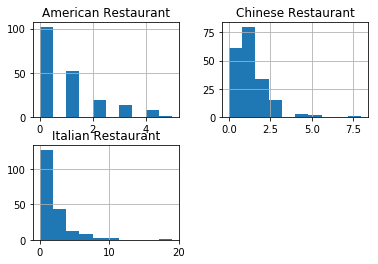

In [14]:
viz = final_df[['American Restaurant','Italian Restaurant','Chinese Restaurant']]
viz.hist()
plt.show()

# CLUSTER 

In [36]:
# set number of clusters
kclusters = 5


final_df_clustering = final_df.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(final_df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_



array([2, 1, 1, 1, 1, 1, 1, 2, 0, 4, 0, 1, 0, 2, 2, 1, 1, 2, 3, 2, 1, 1,
       1, 1, 0, 2, 2, 1, 1, 1, 4, 2, 1, 4, 2, 1, 0, 2, 1, 0, 0, 1, 0, 1,
       2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 2, 1, 0, 1, 1, 2, 0, 2, 0, 1, 0,
       1, 2, 2, 1, 0, 2, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 4, 2, 2, 1, 2, 2,
       0, 1, 0, 2, 1, 1, 2, 2, 1, 1, 4, 1, 0, 2, 2, 1, 2, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 0, 0, 1, 1, 1, 4, 1, 2, 1, 2, 0, 1,
       1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1,
       4, 1, 4, 1, 4, 4, 1, 1, 2, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4],
      dtype=int32)

In [37]:
# add clustering labels
final_df.insert(0, 'Cluster Labels', kmeans.labels_)

ValueError: cannot insert Cluster Labels, already exists

In [38]:
neighborhoods = neighborhoods.sort_values('Neighborhood')
final_df = final_df.sort_values('Neighborhood')

#print(neighborhoods.head(10))
#print(final_df.head(10))

final_df["Latitude"] = ""
final_df["Longitude"] = ""

final_df.head(5)


,Cluster Labels,Neighborhood,American Restaurant,Italian Restaurant,Chinese Restaurant,Latitude,Longitude
0,2,Allerton,0,0,2,,
1,0,Annadale,2,0,0,,
2,0,Arlington,1,0,0,,
3,0,Arrochar,0,2,0,,
4,0,Astoria,0,2,0,,


# Let's add the columns Latitute and Longitude

In [39]:
for index, row in final_df.iterrows():
    final_df.at[index, 'Latitude'] = (neighborhoods.loc[neighborhoods['Neighborhood'] == row['Neighborhood']]["Latitude"]).get_values()[0]
    final_df.at[index, 'Longitude'] = (neighborhoods.loc[neighborhoods['Neighborhood'] == row['Neighborhood']]["Longitude"]).get_values()[0]

final_df.head(5)

,Cluster Labels,Neighborhood,American Restaurant,Italian Restaurant,Chinese Restaurant,Latitude,Longitude
0,2,Allerton,0,0,2,40.8658,-73.8593
1,0,Annadale,2,0,0,40.5381,-74.1785
2,0,Arlington,1,0,0,40.6353,-74.1651
3,0,Arrochar,0,2,0,40.5963,-74.0671
4,0,Astoria,0,2,0,40.7685,-73.9157


# MAP VISUALIZATION

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_df['Latitude'], final_df['Longitude'], final_df['Neighborhood'], final_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Clusters analysis
 
 
clustering is subjective (cit.)

# CLUSTER ZERO

In [41]:
cluster_zero = final_df.loc[final_df['Cluster Labels'] == 0, final_df.columns[[2] + [3] + [4]]].sum(axis = 0, skipna = True) 
cluster_zero['total neighborhoods'] = len(final_df[final_df['Cluster Labels'] == 0])

cluster_zero['total restaurants'] = cluster_zero[0]+cluster_zero[1]+cluster_zero[2]
cluster_zero


American Restaurant     51
Italian Restaurant      70
Chinese Restaurant      67
total neighborhoods    108
total restaurants      188
dtype: int64

# Cluster one

In [21]:
cluster_one = final_df.loc[final_df['Cluster Labels'] == 1, final_df.columns[[2] + [3] + [4]]].sum(axis = 0, skipna = True) 
cluster_one['total neighborhoods'] = len(final_df[final_df['Cluster Labels'] == 1])
cluster_one['total restaurants'] = cluster_one[0]+cluster_one[1]+cluster_one[2]
cluster_one


American Restaurant     26
Italian Restaurant      90
Chinese Restaurant      11
total neighborhoods     12
total restaurants      127
dtype: int64

# Cluster two

In [22]:
cluster_two = final_df.loc[final_df['Cluster Labels'] == 2, final_df.columns[[2] + [3] + [4]]].sum(axis = 0, skipna = True) 
cluster_two['total neighborhoods'] = len(final_df[final_df['Cluster Labels'] == 2])
cluster_two['total restaurants'] = cluster_two[0]+cluster_two[1]+cluster_two[2]
cluster_two


American Restaurant     32
Italian Restaurant      46
Chinese Restaurant     126
total neighborhoods     47
total restaurants      204
dtype: int64

# Cluster three

In [23]:
cluster_three = final_df.loc[final_df['Cluster Labels'] == 3, final_df.columns[[2] + [3] + [4]]].sum(axis = 0, skipna = True) 
cluster_three['total neighborhoods'] = len(final_df[final_df['Cluster Labels'] == 3])
cluster_three['total restaurants'] = cluster_three[0]+cluster_three[1]+cluster_three[2]
cluster_three

American Restaurant     59
Italian Restaurant      96
Chinese Restaurant      19
total neighborhoods     28
total restaurants      174
dtype: int64

# Cluster four

In [26]:
cluster_four = final_df.loc[final_df['Cluster Labels'] == 4, final_df.columns[[2] + [3] + [4]]].sum(axis = 0, skipna = True) 
cluster_four['total neighborhoods'] = len(final_df[final_df['Cluster Labels'] ==4])
cluster_four['total restaurants'] = cluster_four[0]+cluster_four[1]+cluster_four[2]
cluster_four


American Restaurant     1
Italian Restaurant     19
Chinese Restaurant      0
total neighborhoods     1
total restaurants      20
dtype: int64

# Since with this clustering technique results tends to change every time the script is launched, i'll write some conclusions on the final assingment (the relation).